# Notebook Setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, Math


import numpy as np
import matplotlib.pyplot as plt

import os
import sys

sys.path.insert(1, '../')

from moments_toolkit import moments_toolkit

from moments_toolkit import ratio_formula, sum_ratios_formula

import gvar as gv

from moments_toolkit import plateau_search

import itertools as it

import correlatoranalyser as CA

from moments_toolkit import average_moments_over_T
from moments_toolkit import jackknife, jackknife_resamples

# Data Reading

In [2]:
p3fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/3PointCorrelation/"
p2fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/2PointCorrelation/"


opAnalyzer = moments_toolkit(p3fold, p2fold,
                            skip3p=False, skipop=False,
                            verbose=True,
                            fast_data_folder = "../fast_data_extended_p0_q0",
                            operator_folder= "../operator_database",
                            momentum='PX0_PY0_PZ0',
                            insertion_momentum = 'qx0_qy0_qz0',
                            tag_2p='hspectrum',
                            max_n=2 #max_n=3
                            )

#opAnalyzer = moments_toolkit(p3fold, p2fold,
#                            skip3p=False, skipop=False,
#                            verbose=True,
#                            fast_data_folder = "../fast_data_extended_px-2_q0",
#                            operator_folder= "../operator_database",
#                            momentum='PX-2_PY0_PZ0',
#                            insertion_momentum = 'qx0_qy0_qz0',
#                            tag_2p='hspectrum',
#                            max_n=2 #max_n=3
#                            )


Initializing the moments_toolkit class instance...


Initializing the building block class instance...


Reading the the keys of the dataset ...


Reading the 2 point and 3 point correlators from the fast access dataset ...


Reading the list of all the available operators from the database...


Class Initialization Complete!



In [24]:
opAnalyzer.set_resampling_type('bootstrap')
opAnalyzer.set_resampling_type('jackknife')

# Operators Selection

In [25]:
#we take the operators of the paper

opV1 = 1/6 * opAnalyzer.get_operator(2)
opV2 = 1/(3 * np.sqrt(2)) * (opAnalyzer.get_operator(2) - opAnalyzer.get_operator(3))
opV3 = 1/np.sqrt(2) * opAnalyzer.get_operator(14)

opA1 = 1/np.sqrt(2) * opAnalyzer.get_operator(28)
opA2 = 1/np.sqrt(2) * opAnalyzer.get_operator(32)

opT1 = opAnalyzer.get_operator(74) + 1/2 * opAnalyzer.get_operator(78)
opT2 = opAnalyzer.get_operator(78)
opT3 =  1/6 * ( -3 * opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) + 3* opAnalyzer.get_operator(91) + opAnalyzer.get_operator(95) )
opT4 = 1/2 * ( opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) -2* opAnalyzer.get_operator(91) )

In [26]:
#we empty the selected op just to be sure
opAnalyzer.deselect_operator()

#we append the operators
opAnalyzer.append_operator(opV1)
opAnalyzer.append_operator(opV2)
opAnalyzer.append_operator(opV3)
opAnalyzer.append_operator(opA1)
opAnalyzer.append_operator(opA2)
opAnalyzer.append_operator(opT1)
opAnalyzer.append_operator(opT2)
opAnalyzer.append_operator(opT3)
opAnalyzer.append_operator(opT4)

#opAnalyzer.append_operator(opAnalyzer.get_operator(125))


#we deselect the op with 0 kin factor
Klist = opAnalyzer.get_Klist()
eliminate_op = [op for op,kin in zip(opAnalyzer.selected_op,Klist) if np.abs( kin.mean ) == 0]
for op in eliminate_op:
    opAnalyzer.deselect_operator(op)
Klist = opAnalyzer.get_Klist()

In [27]:
opAnalyzer.display_operators()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# R plots

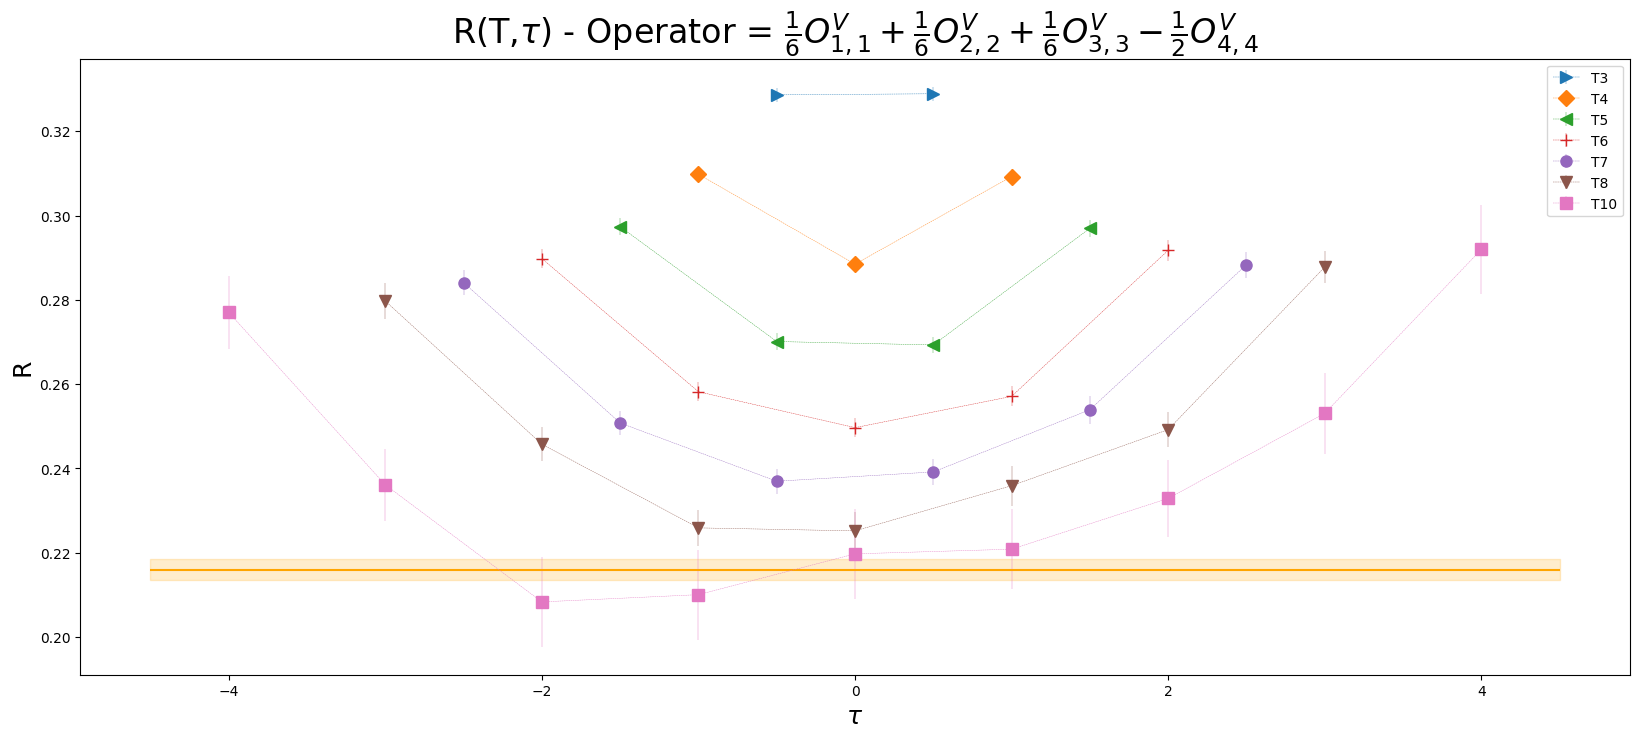

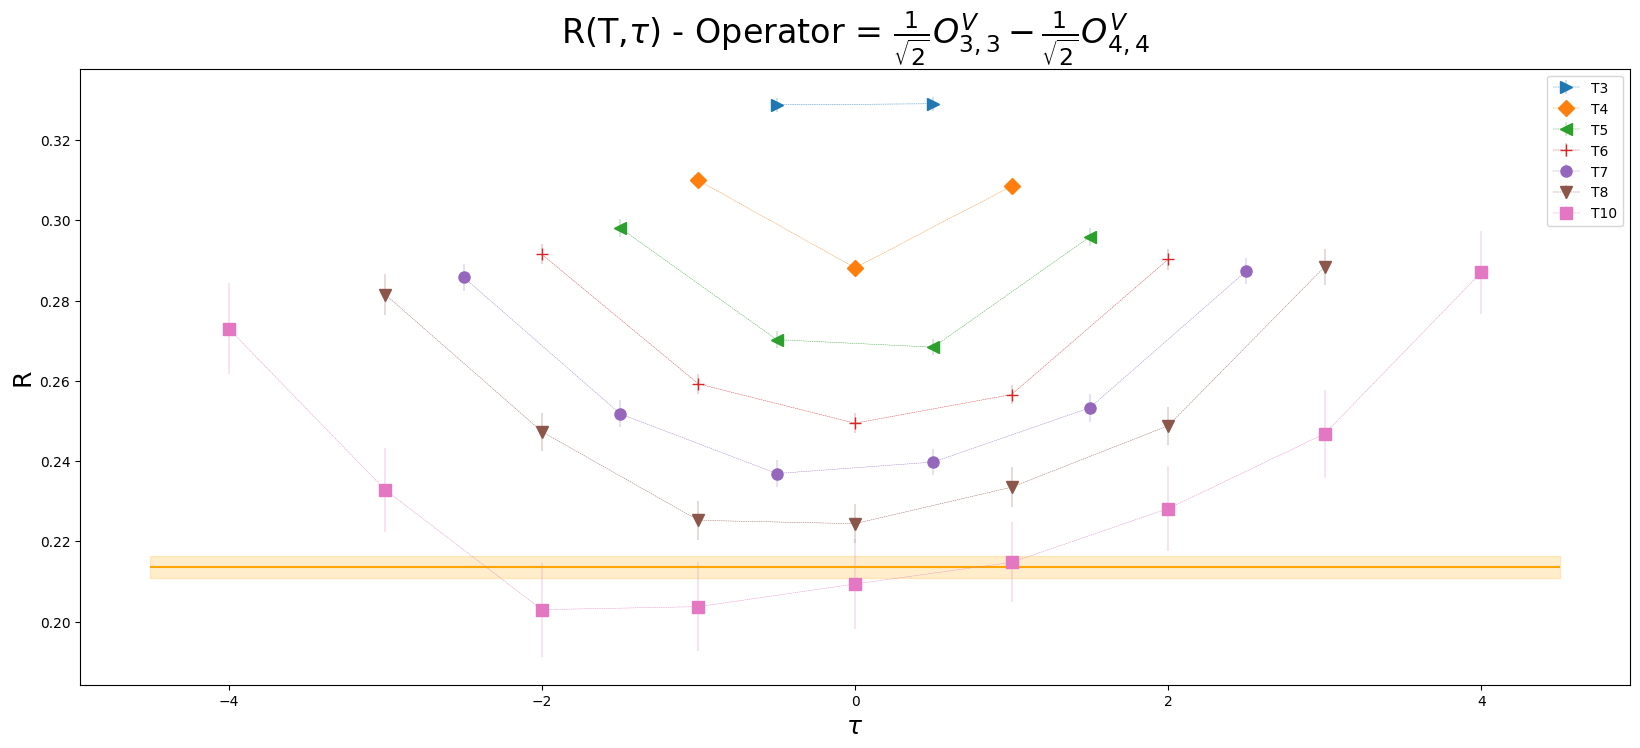

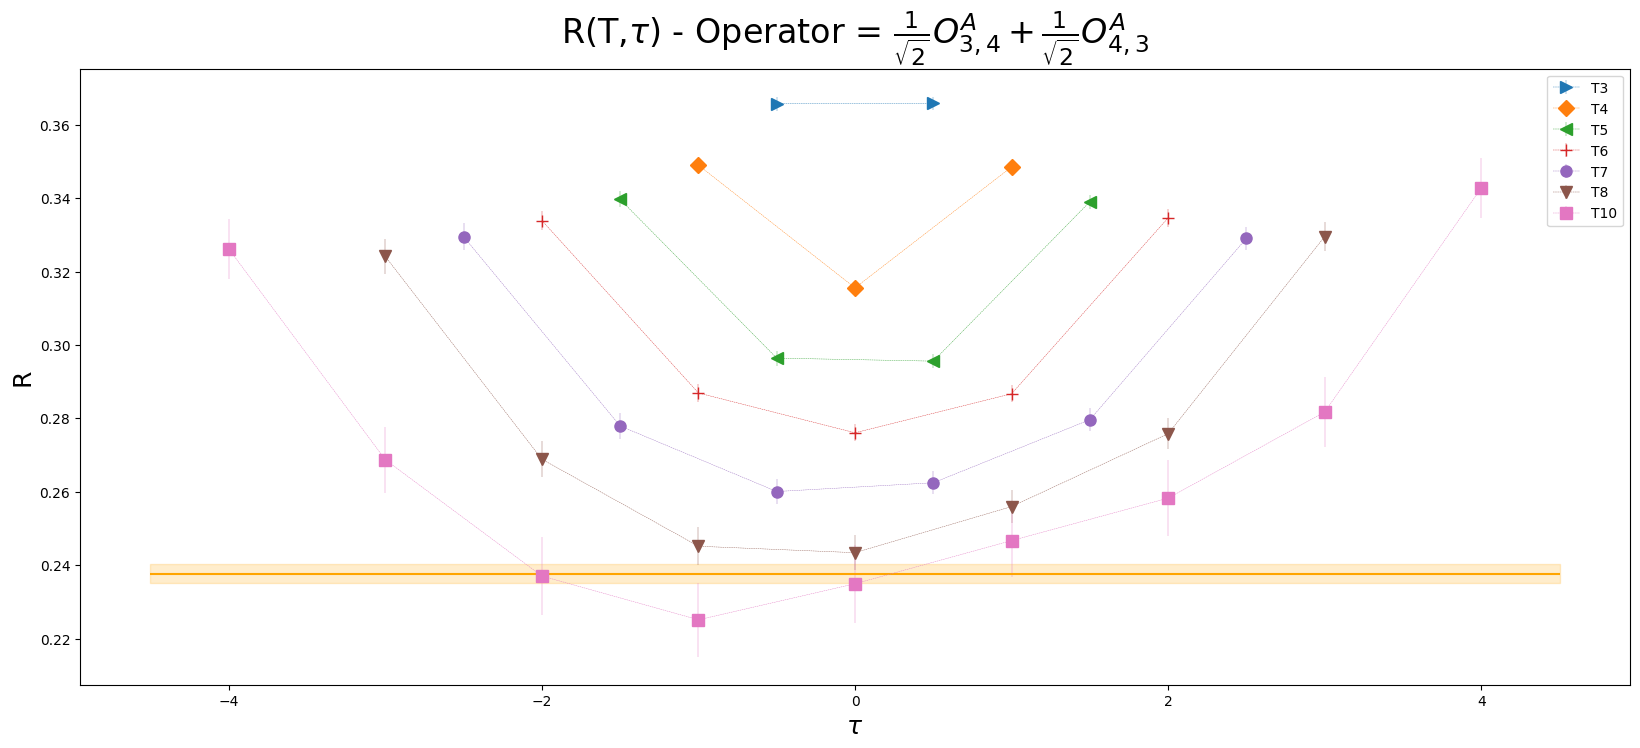

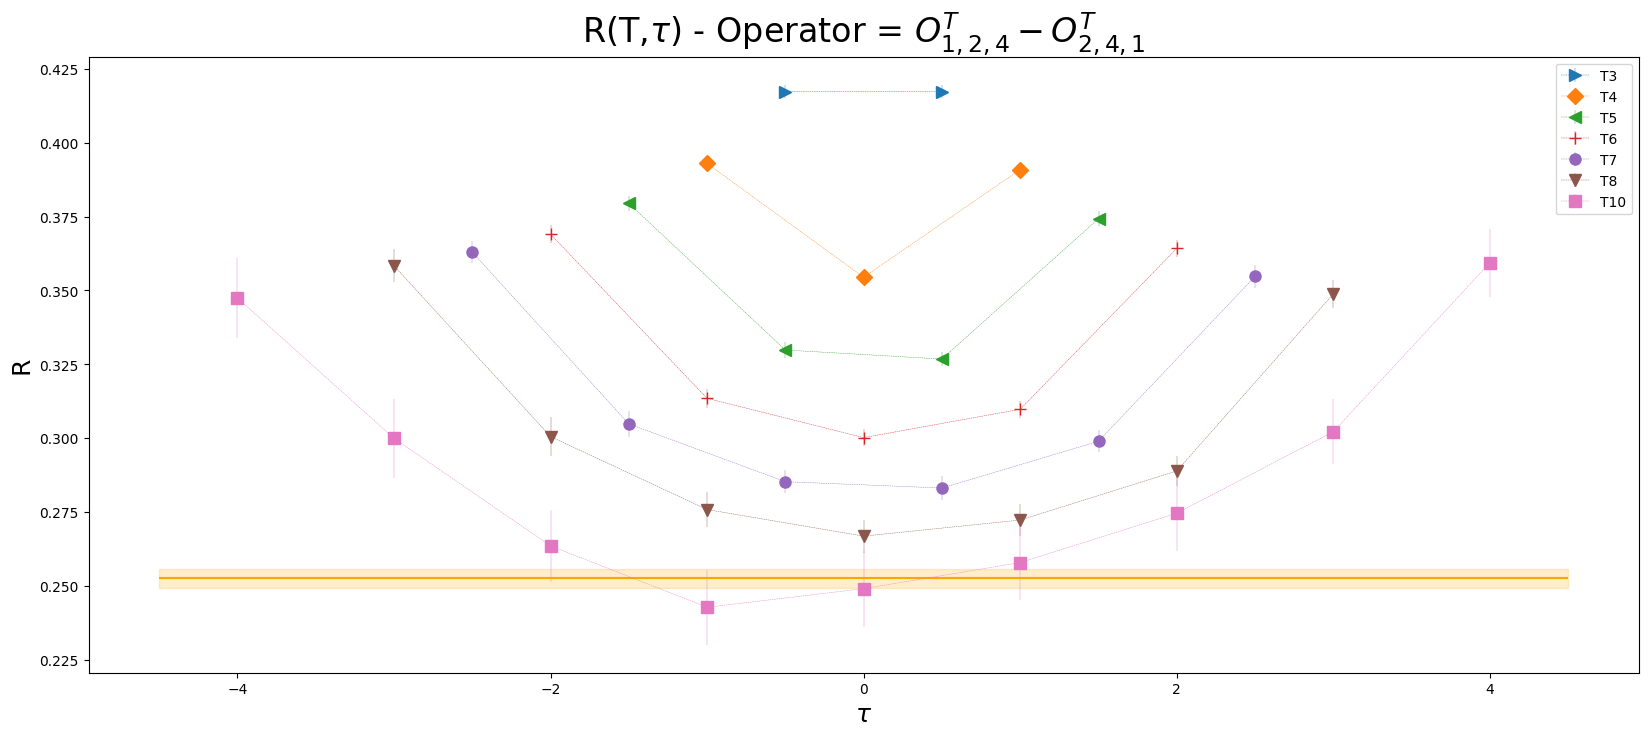

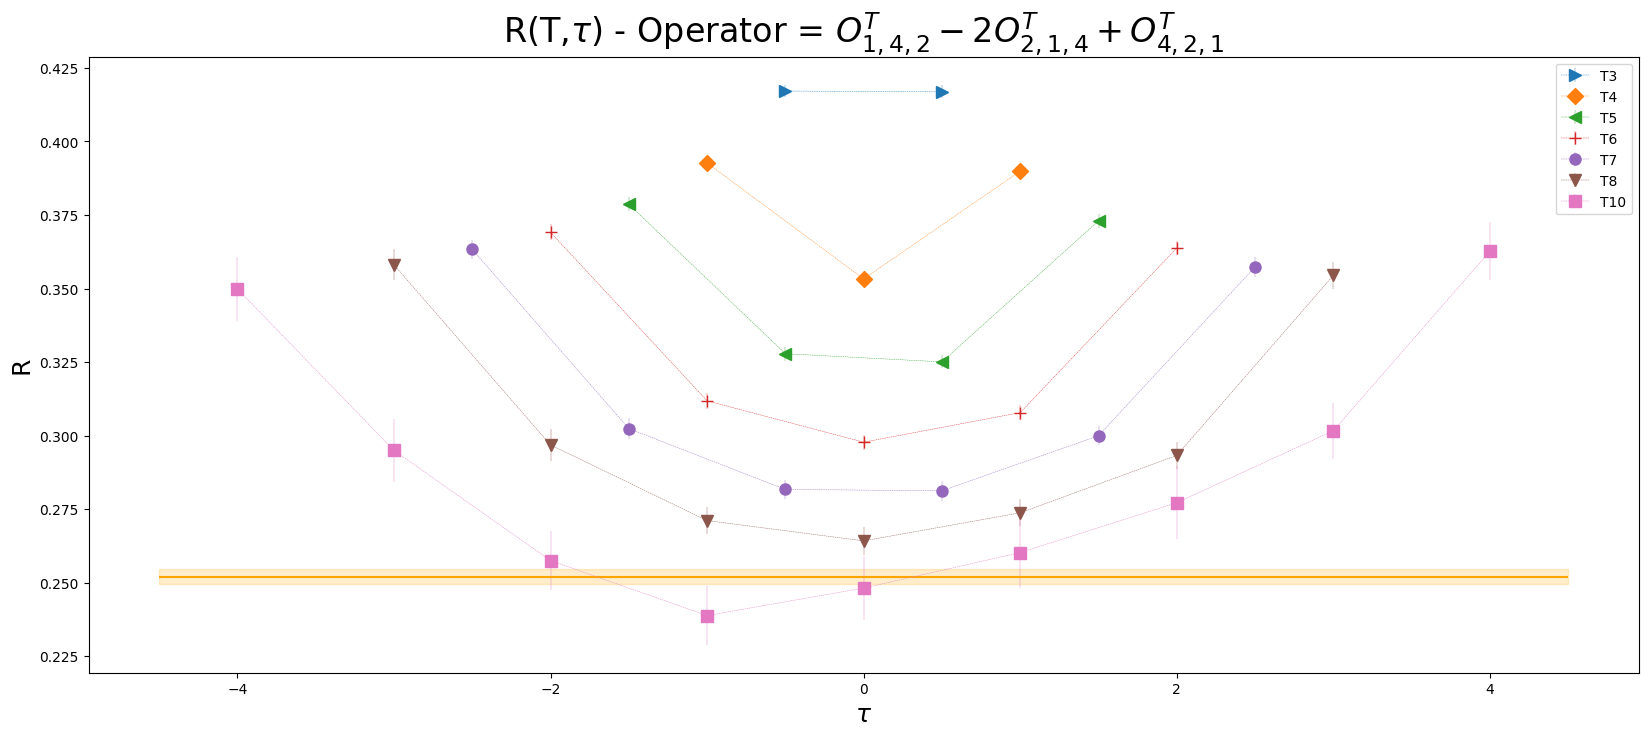

In [28]:
opAnalyzer.remove_T()

matele_fromS = opAnalyzer.get_M_from_S(method="fit", tskip_list=[1,2,3],moments=True)


opAnalyzer.remove_T(12)


fig_ax_list = opAnalyzer.plot_R(rescale=True,show=False,save=True)





#Klist = opAnalyzer.get_Klist()

for iop, fig_ax in enumerate(fig_ax_list):

    fig, ax = fig_ax

    op = opAnalyzer.selected_op[iop]

    

    mat_ele_avg = average_moments_over_T(matele_fromS[iop], chi2=1.0) #/ Klist[iop]
    #mat_ele_avg

    T=11

    _ = ax.hlines(mat_ele_avg.mean,-T/2+1,T/2-1,linestyle="solid", color="orange")
    #ax.hlines(mat_ele_avg.mean + mat_ele_avg.std, -T/2+1,T/2,linestyle="solid", color="orange", alpha)
    #ax.hlines(mat_ele_avg.mean - mat_ele_avg.std,-T/2+1,T/2,linestyle="solid", color="orange")
    _ = ax.fill_between(np.arange(-T/2+1,T/2), mat_ele_avg.mean - mat_ele_avg.sdev, mat_ele_avg.mean + mat_ele_avg.sdev, alpha=0.2, color="orange")

plt.show()

# One Operator Analysis

## Fix iop

In [29]:
iop = 2

## Plateau Search

In [30]:
from utilities import redchi2_cov

#function that given a 1D array returns the values of the indices identifying its plateau (the first and last index)
def plateau_search_symm(in_array: np.ndarray, covmat: np.ndarray, chi2_treshold:float=1.0, only_sig:bool=True) -> tuple[int,int]:
    """
    Input:
        - in_array: the 1D array we want to search the plateau of
        - covmat: a 2D array, representing the covariance matrix of in_array
        - chi2_treshold: the treshold for the plateau determination
        - only_sig: bool, if True only the standard deviation, and not the whole cavariance matrix, is used for the plateau determination
    
    Output:
        - (start_plateau,end_plateau): indices such that in_array[start_plateau,end_plateau] is the region with the plateau
    """

    #first we compute the len of the array
    len_array = np.shape(in_array)[0]

    #we loop over all the possible plateau lenghts, starting from the biggest possible one and then diminishing it up to a plataeau of len 2
    for len_plat in range(len_array,1,-2):

        start_plateau = int( (len_array-len_plat)/2 )

        #the suggested plateau region in this case is
        plat = in_array[start_plateau:start_plateau+len_plat]

        #we also have to reshape the covariance matrix
        covmat_plat = covmat[start_plateau:start_plateau+len_plat, start_plateau:start_plateau+len_plat]

        #the value of the plateau is
        plat_value = np.average(plat, weights = np.diag(np.linalg.inv(covmat_plat)), axis=0, keepdims=True) #the weights are the inverse of the sigma squared

        #we compute the chi2 of the current plateau
        chi2 = redchi2_cov(plat, plat_value, covmat_plat,only_sig=only_sig)

        #we see if the chi2 meets the condition
        if chi2 < chi2_treshold: #TO DO: in this case put the value in a list and then at the end of the inner loop search for the better one

            return start_plateau, start_plateau+len_plat
                
    #if by the end of the loop the chi2 condition is never met (i.e. if len_plat is 1) we return the point corresponding to the middle of the dataset
    return int(len_array/2), int(len_array/2)+2-len_array%2

In [31]:
opAnalyzer.remove_T(12,verbose=True)
Rmean,Rstd,Rcov = opAnalyzer.get_R()

"(Nop,NT,maxT+1)"
Rmean.shape

Tlist = opAnalyzer.chosen_T_list


Available source-skink separation values: [3, 4, 5, 6, 7, 8, 10, 12]
Chosen source-sink separation values: [3, 4, 5, 6, 7, 8, 10]


'(Nop,NT,maxT+1)'

(5, 7, 11)

In [32]:
for iT,T in enumerate(Tlist):
    plateau_search_symm(Rmean[iop,iT,:T+1],Rcov[iop,iT,:T+1,:T+1])

(1, 3)

(2, 3)

(2, 4)

(3, 4)

(3, 5)

(4, 5)

(4, 7)

### plot

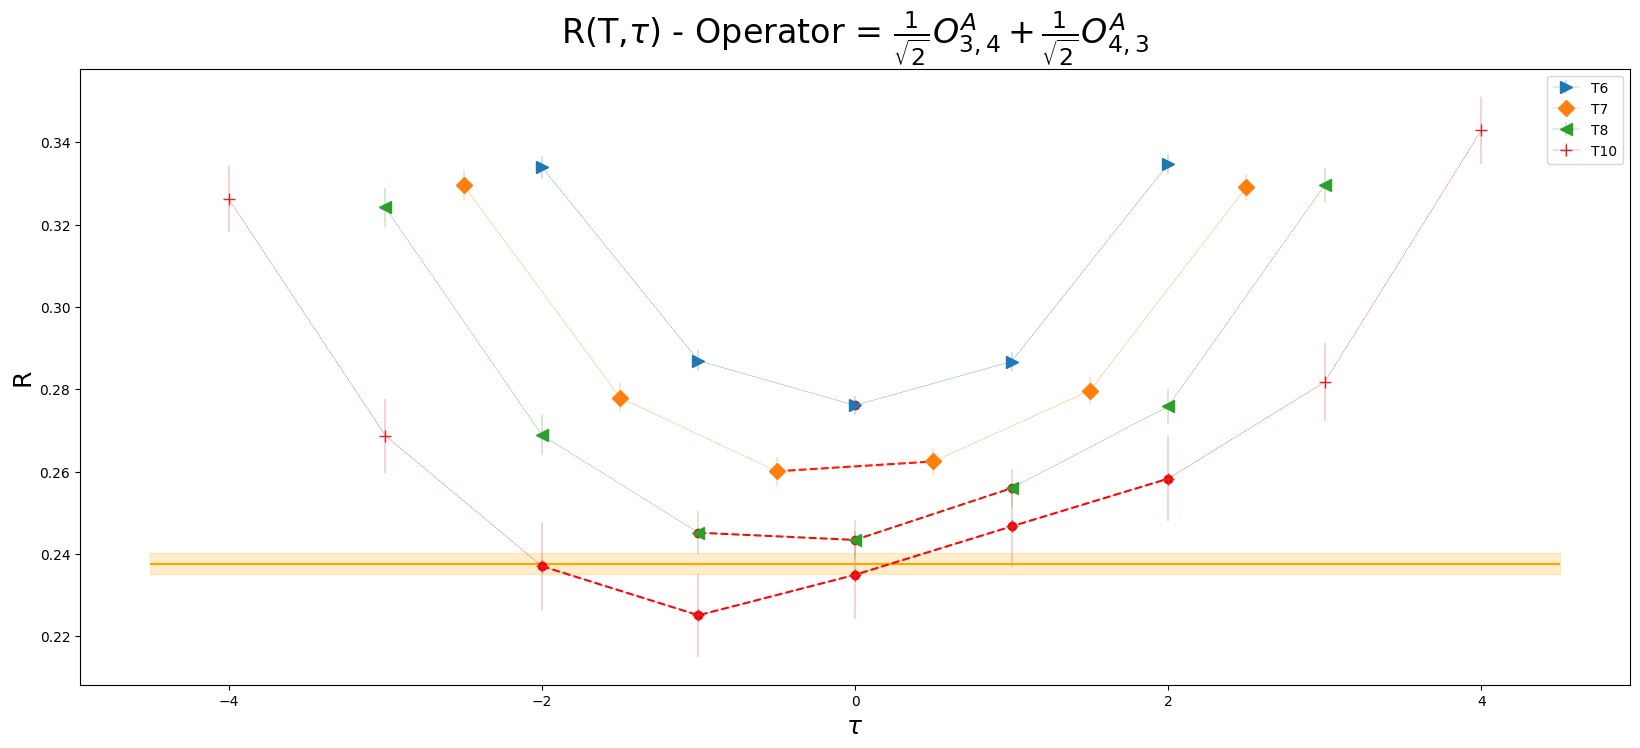

In [33]:
opAnalyzer.remove_T(3,4,5,12)
Rmean,Rstd,Rcov = opAnalyzer.get_R()


fig_ax_list = opAnalyzer.plot_R(rescale=True,show=False,save=True)



fig, ax = fig_ax_list[iop]

op = opAnalyzer.selected_op[iop]



mat_ele_avg = average_moments_over_T(matele_fromS[iop], chi2=5.0) #/ Klist[iop]
#mat_ele_avg

Tmax=11

_ = ax.hlines(mat_ele_avg.mean,-Tmax/2+1,Tmax/2-1,linestyle="solid", color="orange")
_ = ax.fill_between(np.arange(-Tmax/2+1,Tmax/2), mat_ele_avg.mean - mat_ele_avg.sdev, mat_ele_avg.mean + mat_ele_avg.sdev, alpha=0.2, color="orange")


for iT,T in enumerate(opAnalyzer.chosen_T_list):

    times = np.arange(-T/2+1,T/2)

    ratio = Rmean[iop,iT,1 : T+1 -1]
    ratio_err = Rstd[iop,iT, 1 :T+1 -1]

    pstart, pstop = plateau_search_symm(Rmean[iop,iT,1 : T+1 -1],Rcov[iop,iT,1 : T+1 -1, 1 : T+1 -1], chi2_treshold=2.5)

    plat = ratio[pstart:pstop] / Klist[iop].mean


    _=ax.plot(times[pstart:pstop],plat,color="red",marker="o",alpha=1,linestyle="dashed")



for jop in range(opAnalyzer.Nop):
    if jop!=iop:
        plt.close(fig_ax_list[jop][0])

plt.show()

## Fit Data Preparation

In [34]:
Rmean,Rstd,Rcov = opAnalyzer.get_R()
Rmean[iop]

array([[ 0.07521206, -0.13428718, -0.11538214, -0.11101993, -0.1152988 ,
        -0.13458141,  0.07515885,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.07758542, -0.13251023, -0.11176158, -0.10458284, -0.10554275,
        -0.11245562, -0.13233869,  0.0775835 ,  0.        ,  0.        ,
         0.        ],
       [ 0.07879292, -0.13034278, -0.10812209, -0.09858497, -0.09788097,
        -0.10293425, -0.1109194 , -0.13253331,  0.0769704 ,  0.        ,
         0.        ],
       [ 0.086076  , -0.13117861, -0.10806511, -0.09531965, -0.09052346,
        -0.09447393, -0.09920499, -0.10386008, -0.11330368, -0.13786029,
         0.08025251]])

In [35]:
abscissa = []

plat_dict = {}

for iT,T in enumerate(opAnalyzer.chosen_T_list):

    times = np.arange(-T/2+1,T/2)

    ratio = Rmean[iop,iT,1 : T+1 -1]
    ratio_err = Rstd[iop,iT, 1 :T+1 -1]

    pstart, pstop = plateau_search_symm(Rmean[iop,iT,1 : T+1 -1],Rcov[iop,iT,1 : T+1 -1, 1 : T+1 -1], chi2_treshold=2.5)
    plat_dict[T] = ( pstart, pstop )

    for t in range(pstart,pstop):
        abscissa.append((T,t+1)) #+1 due to the fact we discarded the endpoints

abscissa = np.asarray(abscissa,dtype=float)
abscissa.shape
abscissa

#abscissa = np.asarray(abscissa).flatten
plat_dict

(11, 2)

array([[ 6.,  3.],
       [ 7.,  3.],
       [ 7.,  4.],
       [ 8.,  3.],
       [ 8.,  4.],
       [ 8.,  5.],
       [10.,  3.],
       [10.,  4.],
       [10.,  5.],
       [10.,  6.],
       [10.,  7.]])

{6: (2, 3), 7: (2, 4), 8: (2, 5), 10: (2, 7)}

In [36]:
p3corr = opAnalyzer.get_p3corr()[iop] #shape = (Nconf,NT,maxT+1)
p2corr = opAnalyzer.get_p2corr() #shape = (nconf,latticeT)

In [37]:
def flatten_list(input_list:list) -> list:
    return [element for inner_list in input_list for element in inner_list]

In [38]:
Rjack_mean, Rjack_std, Rjack_cov = jackknife([p3corr,p2corr], lambda x,y: np.asarray( flatten_list( [ ratio_formula(x, y, T, gauge_axis=0)[iT,1+plat_dict[T][0]:1+plat_dict[T][1]] for iT,T in enumerate(opAnalyzer.chosen_T_list) ]  ) ), res_axis_list=[0,0] , time_axis=-1)
gv.gvar(Rjack_mean,Rjack_std) / Klist[iop]

array([0.2761(24), 0.2601(35), 0.2625(32), 0.2452(52), 0.2434(48),
       0.2560(46), 0.237(11), 0.225(10), 0.235(11), 0.2467(98), 0.258(10)],
      dtype=object)

In [39]:
Klist

[0.2843(13), 0.4021(19), -0.4021(19), 0.5687(26), 1.1373(52)]

In [40]:
Rjack_resamples = jackknife_resamples([p3corr,p2corr], lambda x,y: np.asarray( flatten_list( [ ratio_formula(x, y, T, gauge_axis=0)[iT,1+plat_dict[T][0]:1+plat_dict[T][1]] for iT,T in enumerate(opAnalyzer.chosen_T_list) ]  ) ), res_axis_list=[0,0] )
Rjack_resamples.shape
Nres = Rjack_resamples.shape[0]

(212, 11)

## Fit

### Functional Form

In [41]:
class ratio_func_form:

    def __init__(self,r1:bool=True,r2:bool=True,r3:bool=False):
        self.r1:bool=r1
        self.r2:bool=r2
        self.r3:bool=r3
        
    def __call__(self, t:tuple[int,int], parms:dict):

        #we grep the input
        T = t[:,0]
        tau = t[:,1]
        MatEle = parms["M"]
        R1 = parms["R1"]
        R2 = parms["R2"]
        R3 = parms["R3"]
        dE = parms["dE"]

        out = MatEle

        fact = 1.0

        if self.r1:
            #out += np.sqrt(R1*R1) * np.exp(-T/2*dE)*np.cosh( (T/2 - tau) * dE)
            fact += R1 * np.exp(-T/2*dE)* np.cosh( (T/2 - tau) * dE)
        if self.r2:
            fact += R2 * np.exp(-T*dE)

        if self.r3:
            fact /= (1 + R3**2 * np.exp(-T*dE))

        return out*fact

### Prior

In [95]:
opAnalyzer.remove_T()
matele_fromS = opAnalyzer.get_M_from_S(method="fit", tskip_list=[1,2,3],moments=False)
opAnalyzer.remove_T(3,4,5,12)
mat_ele_avg = average_moments_over_T(matele_fromS[iop], chi2=2.0)

E0 = opAnalyzer.get_E()

prior = gv.BufferDict()

fit2p = opAnalyzer.fit_2pcorr(show=False,save=False)
fit2p_parms = fit2p.model_average()
dE1 = gv.gvar(fit2p_parms['est']['dE1'], fit2p_parms['err']['dE1'])

prior["dE"] = dE1#*10 #gv.gvar(E0.mean,E0.mean)            ####################### TO DO: do computation and understand who is this deltaE

prior["M"] = mat_ele_avg

i_probe = 0
Tprobe,tprobe = abscissa[i_probe]
Rprobe = Rjack_mean[i_probe]

r1_mean = (Rprobe/mat_ele_avg.mean -1 ) * np.exp(Tprobe/2 * dE1.mean) / np.cosh((Tprobe/2-tprobe)*dE1.mean)


prior["R1"] = gv.gvar(r1_mean,3*r1_mean)
prior["R2"] = gv.gvar(r1_mean,3*r1_mean)/2
prior["R3"] = np.sqrt( gv.gvar(r1_mean,3*r1_mean)/2 )


#TO DO: log prior for dE

prior["M"] = gv.gvar(0.0,100000)
#prior["dE"] = gv.gvar(0.0,100000)
prior["R1"] = gv.gvar(0.0,100000)
prior["R2"] = gv.gvar(0.0,100000)
prior["R3"] = gv.gvar(0.0,100000)
prior

BufferDict({'dE': 0.08226(27), 'M': 0 ± 1.0e+05, 'R1': 0 ± 1.0e+05, 'R2': 0 ± 1.0e+05, 'R3': 0 ± 1.0e+05})

In [96]:
#lis = []
#for i_probe in range(len(Rjack_mean)):
#    Tprobe,tprobe = abscissa[i_probe]
#    Rprobe = Rjack_mean[i_probe]
#
#    r1_mean = (Rprobe/mat_ele_avg.mean -1 ) * np.exp(Tprobe/2 * dE1.mean) / np.cosh((Tprobe/2-tprobe)*dE1.mean)
#    r1_mean
#    lis.append(r1_mean)
#
#plt.plot(np.arange(len(list)))

### Fit Routine

In [97]:
gv.gvar(Rjack_mean, Rjack_std)

array([-0.11102(80), -0.1046(13), -0.1055(12), -0.0986(20), -0.0979(19),
       -0.1029(18), -0.0953(43), -0.0905(40), -0.0945(43), -0.0992(39),
       -0.1039(41)], dtype=object)

In [98]:
fit_res = CA.fit(

    abscissa                = abscissa,
    
    ordinate_est            = Rjack_mean,
    ordinate_std            = Rjack_std,
    ordinate_cov            = Rjack_cov,
    
    resample_ordinate_est   = Rjack_resamples,
    resample_ordinate_std   = np.sqrt((Nres-1)/Nres) * np.std(Rjack_resamples, axis = 0),
    resample_ordinate_cov   = (Nres-1)/Nres * np.cov(Rjack_resamples, rowvar=False),

    # fit strategy, default: only uncorrelated central value fit:
    central_value_fit            = True,
    central_value_fit_correlated = False,

    resample_fit                 = False,
    resample_fit_correlated      = False,
    
    resample_fit_resample_prior  = False,
    resample_type               = "bst",#"jkn",

    # args for lsqfit:
    model   = ratio_func_form(r1=True,r2=True,r3=True),
    prior   = prior,
    p0      = None,

    svdcut  = None,
    maxiter = 10_000,
)

In [99]:
abscissa

array([[ 6.,  3.],
       [ 7.,  3.],
       [ 7.,  4.],
       [ 8.,  3.],
       [ 8.,  4.],
       [ 8.,  5.],
       [10.,  3.],
       [10.,  4.],
       [10.,  5.],
       [10.,  6.],
       [10.,  7.]])

In [100]:
fit_res.best_fit_param

{'dE': 0.08226(27),
 'M': -0.00006(226),
 'R1': 0.02(1.00)e+05,
 'R2': 0.02(1.02)e+04,
 'R3': 0.00042492 ± 2.4e+03}

In [101]:
fit_res.best_fit_param["M"] /Klist[iop]
fit_res.eval(abscissa)["est"] / Klist[iop]

0.0001(56)

array([0.2743(13), 0.2630(12), 0.2630(12), 0.2525(12), 0.2517(12),
       0.2525(12), 0.2339(11), 0.2317(11), 0.2310(11), 0.2317(11),
       0.2339(11)], dtype=object)

### plot

In [102]:
plat_dict

{6: (2, 3), 7: (2, 4), 8: (2, 5), 10: (2, 7)}

In [103]:
best_fit_R = gv.gvar(fit_res.eval(abscissa)["est"], fit_res.eval(abscissa)["err"]) / Klist[iop]

In [104]:
best_fit_R
abscissa

array([0.2743(23), 0.2630(19), 0.2630(19), 0.2525(21), 0.2517(28),
       0.2525(21), 0.2339(64), 0.2317(35), 0.2310(34), 0.2317(35),
       0.2339(64)], dtype=object)

array([[ 6.,  3.],
       [ 7.,  3.],
       [ 7.,  4.],
       [ 8.,  3.],
       [ 8.,  4.],
       [ 8.,  5.],
       [10.,  3.],
       [10.,  4.],
       [10.,  5.],
       [10.,  6.],
       [10.,  7.]])

[3.]
[3. 4.]
[3. 4. 5.]
[3. 4. 5. 6. 7.]


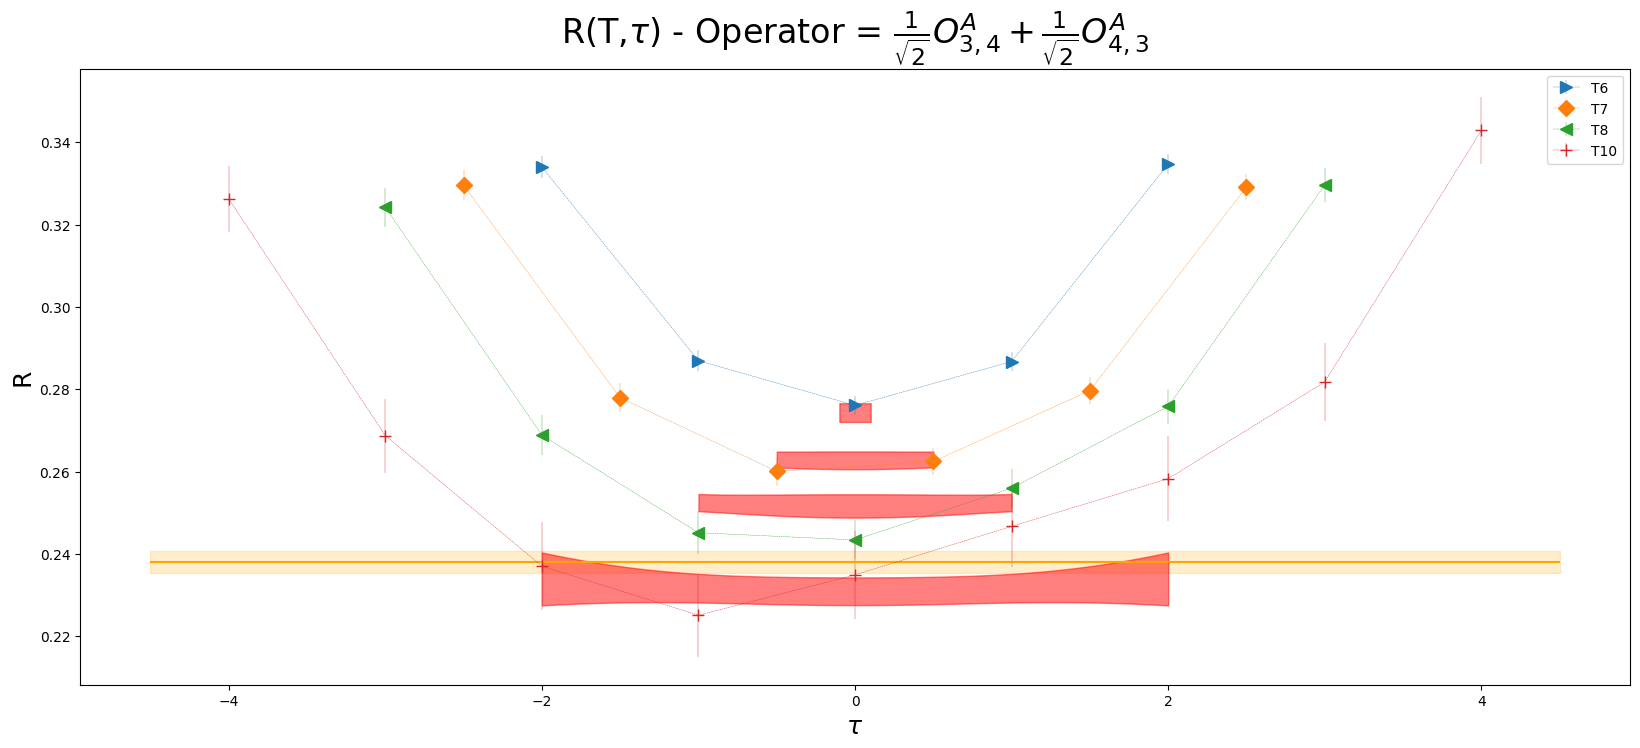

In [105]:
opAnalyzer.remove_T(3,4,5,12)
#Rmean,Rstd,Rcov = opAnalyzer.get_R()


fig_ax_list = opAnalyzer.plot_R(rescale=True,show=False,save=True)



fig, ax = fig_ax_list[iop]

op = opAnalyzer.selected_op[iop]



mat_ele_avg = average_moments_over_T(matele_fromS[iop], chi2=2.0) / Klist[iop]
#mat_ele_avg

Tmax=11

_ = ax.hlines(mat_ele_avg.mean,-Tmax/2+1,Tmax/2-1,linestyle="solid", color="orange")
_ = ax.fill_between(np.arange(-Tmax/2+1,Tmax/2), mat_ele_avg.mean - mat_ele_avg.sdev, mat_ele_avg.mean + mat_ele_avg.sdev, alpha=0.2, color="orange")


for iT,T in enumerate(opAnalyzer.chosen_T_list):

    times = np.arange(-T/2+1,T/2)

    # = Rmean[iop,iT,1 : T+1 -1]
    #ratio_err = Rstd[iop,iT, 1 :T+1 -1]

    #pstart, pstop = plateau_search_symm(Rmean[iop,iT,1 : T+1 -1],Rcov[iop,iT,1 : T+1 -1, 1 : T+1 -1], chi2_treshold=2.5)

    #plat = ratio[pstart:pstop] / Klist[iop].mean


    #_=ax.plot(times[pstart:pstop],plat,color="red",marker="o",alpha=1,linestyle="dashed")

    if T in plat_dict:

        fit_x = abscissa[np.where(abscissa[:,0]==T)][:,1]
        print(fit_x)

        fit_y = best_fit_R[ np.where(abscissa[:,0]==T) ][0]
        #fit_y

        #range_x = np.arange(fit_x[0],fit_x[-1]+1) - T/2 if len(fit_x)>1 else np.arange(fit_x[0],fit_x[-1]+1)
        #range_x += 0 if len(fit_x)>1 else 0.1
        #range_x

        eps = 0 if len(fit_x) > 1 else 0.1
        linspace_x = np.linspace(min(fit_x)-eps,max(fit_x)+eps,100)
        evaluate_x = np.asarray( [(T,t) for t in linspace_x ] )
        #evaluate_x

        fit_y = gv.gvar(fit_res.eval(evaluate_x)["est"], fit_res.eval(evaluate_x)["err"]) / Klist[iop]
        #fit_y
        fity_low = np.asarray( [ y.mean - y.sdev for y in fit_y])
        fity_high = np.asarray( [ y.mean + y.sdev for y in fit_y])

        _ = ax.fill_between(linspace_x-T/2, fity_low, fity_high, alpha=0.5, color="red")







for jop in range(opAnalyzer.Nop):
    if jop!=iop:
        plt.close(fig_ax_list[jop][0])

plt.show()

# Systematic Study

# Debugging

In [106]:
class ratio_func_form2:

    def __init__(self,r1:bool=True,r2:bool=True,r3:bool=False):
        self.r1:bool=r1
        self.r2:bool=r2
        self.r3:bool=r3
        
    def __call__(self, t:tuple[int,int], parms:dict):

        #we grep the input
        T = t[:,0]
        print(f"T={T}")
        tau = t[:,1]
        print(f"tau={tau}")
        MatEle = parms["M"]
        R1 = parms["R1"]
        R2 = parms["R2"]
        R3 = parms["R3"]
        dE = parms["dE"]

        out = MatEle

        fact = 1.0

        if self.r1:
            #out += np.sqrt(R1*R1) * np.exp(-T/2*dE)*np.cosh( (T/2 - tau) * dE)
            fact += R1 * np.exp(-T/2*dE)* np.cosh( (T/2 - tau) * dE)
        if self.r2:
            fact += R2 * np.exp(-T*dE)

        if self.r3:
            fact /= (1 + R3 * np.exp(-T*dE))

        return out*fact

In [107]:
opAnalyzer.lattice_to_MeV(prior["dE"])

139.57(67)

In [108]:
func = ratio_func_form2(r1=True,r2=False,r3=False)

func(abscissa, prior*10)

T=[ 6.  7.  7.  8.  8.  8. 10. 10. 10. 10. 10.]
tau=[3. 3. 4. 3. 4. 5. 3. 4. 5. 6. 7.]


array([0 ± 1.0e+06, 0 ± 1.0e+06, 0 ± 1.0e+06, 0 ± 1.0e+06, 0 ± 1.0e+06,
       0 ± 1.0e+06, 0 ± 1.0e+06, 0 ± 1.0e+06, 0 ± 1.0e+06, 0 ± 1.0e+06,
       0 ± 1.0e+06], dtype=object)